# Classifying Titles by Fine Tuning Transformers

In this notebook, I classify Reddit post titles into 'Conservative' or 'Liberal' posts. To accomplish this, I fine tune a pretrained model (downloaded from HuggingFace).

The data can be found [here](http://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts).

I referenced many materials to complete this and related notebooks, including [*Deep Learning with Python*](http://https://www.manning.com/books/deep-learning-with-python) by François Chollet and [*Natural Language Processing with Transformers*](http://https://www.oreilly.com/library/view/natural-language-processing/9781098103231/) by Lewis Tunstall, Leandro von Werra, Thomas Wolf.

In [1]:
# imports and installs

import numpy as np
import pandas as pd
import os

!pip install -U transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.18.0
    Uninstalling transformers-4.18.0:
      Successfully uninstalled transformers-4.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.19.2 which is incompatible.


In [2]:
# load data into HuggingFace dataset

from datasets import load_dataset
dataset = load_dataset('csv', data_files='../input/liberals-vs-conservatives-on-reddit-13000-posts/file_name.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-97df9714d000b2a9/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# change dataset to pandas dataframe to prepare data
# drop irrelevant columns and shuffle dataset

dataset.set_format(type="pandas")
df = dataset["train"][:]
df = df.drop(columns=['Score', 'Id', 'Subreddit', 'URL', 'Num of Comments','Date Created', 'Text'])
df = df.dropna()
df.sample(frac=1)

,Title,Political Lean
11060,"Pot Won't Be Advertised at Super Bowl, Though ...",Conservative
5755,Newly revealed emails add to 'growing body of ...,Liberal
2469,Pelosi fast-tracks bill to funnel more weapons...,Liberal
300,Monthly Organizing Acomplishments Thread for F...,Liberal
398,Where do you get your news from ? Any good you...,Liberal
...,...,...
9624,"Let's Go, Brandon! 5 Major Economies Whose Lea...",Conservative
5769,Most Republicans want Trump as the GOP's leade...,Liberal
8299,"""People Beware! Mousavi is not your brother an...",Liberal
8729,What is Really Going on in Ukraine? An Alterna...,Conservative


In [4]:
# encode labels

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["Political Lean"])
df["Political Lean"] = le.transform(df["Political Lean"])

In [5]:
# convert back into HuggingFace dataset, rename "Political Lean"

from datasets import Dataset

politics = Dataset.from_pandas(df)
politics = politics.rename_column("Political Lean", "label")
politics

Dataset({
    features: ['Title', 'label', '__index_level_0__'],
    num_rows: 12854
})

In [6]:
# split the data into 90% train, 5% val, and 5% test
train_test = politics.train_test_split(test_size=0.1)
test_valid = train_test['test'].train_test_split(test_size=0.5)

# gather splits into single dataset
from datasets import DatasetDict
politics = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

politics

DatasetDict({
    train: Dataset({
        features: ['Title', 'label', '__index_level_0__'],
        num_rows: 11568
    })
    test: Dataset({
        features: ['Title', 'label', '__index_level_0__'],
        num_rows: 643
    })
    valid: Dataset({
        features: ['Title', 'label', '__index_level_0__'],
        num_rows: 643
    })
})

In [7]:
# remove added column

politics = politics.remove_columns(['__index_level_0__'])

In [8]:
# tokenizing the text from pretrained model

from transformers import AutoTokenizer

model_ckpt = "m-newhauser/distilbert-political-tweets"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [9]:
# tokenize all data

def tokenize(batch):
    return tokenizer(batch["Title"], padding=True, truncation=True, max_length=30)

politics_encoded = politics.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
# look at the updated dataset

politics_encoded

DatasetDict({
    train: Dataset({
        features: ['Title', 'label', 'input_ids', 'attention_mask'],
        num_rows: 11568
    })
    test: Dataset({
        features: ['Title', 'label', 'input_ids', 'attention_mask'],
        num_rows: 643
    })
    valid: Dataset({
        features: ['Title', 'label', 'input_ids', 'attention_mask'],
        num_rows: 643
    })
})

In [11]:
# downloading pretrained model for classification, moving model onto GPU

from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to("cuda"))

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [12]:
# function to report scores after training model

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [13]:
# preparing training args for model

from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(politics_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-politics"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  report_to="none",
                                  log_level="error")

In [14]:
# defining and training the model 

from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=politics_encoded["train"],
                  eval_dataset=politics_encoded["valid"],
                  tokenizer=tokenizer)
trainer.train();

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.606900,0.475658,0.758942,0.749025,0.771186,0.885645
2,0.374100,0.533251,0.779160,0.769469,0.783158,0.905109
3,0.249100,0.935859,0.772939,0.769968,0.804598,0.851582
4,0.160100,1.253778,0.768274,0.763553,0.793722,0.861314
5,0.098400,1.435942,0.758942,0.755015,0.790909,0.846715


In [15]:
# looking at metrics

preds_output = trainer.predict(politics_encoded["test"])
preds_output.metrics

{'test_loss': 1.6663485765457153,
 'test_accuracy': 0.7340590979782271,
 'test_f1': 0.7318253407365483,
 'test_precision': 0.7716346153846154,
 'test_recall': 0.8085642317380353,
 'test_runtime': 0.8188,
 'test_samples_per_second': 785.295,
 'test_steps_per_second': 98.925}

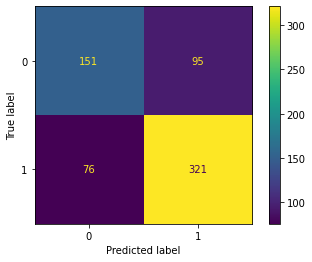

In [16]:
# looking at the confusion matrix

preds = np.argmax(preds_output.predictions, axis=1)
labels = np.array(preds_output.label_ids)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()